In [1]:
import numpy as np
import scipy as sp
from scipy.stats import qmc
import numpy.random as random
import vegas

In [2]:
class particle:
     def __init__(self, alive, mu, x, weight):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.weight = weight

In [3]:
def mc_iso_vegas(sigmaS, sigmaA, q, L, x, mu, bias):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)
        
    #create particle
    p = particle(True, mu, x, q/W)

    while p.alive:
        #calculate distance to collision
        distance_to_collision = abs(-np.log(np.random.random())/sigmaT)

        #calculate distance to boundary
        if p.mu < 0:
            distance_to_boundary = abs(p.x/p.mu)
        elif p.mu >= 0:
            distance_to_boundary = (L-p.x)/p.mu

        #tally if distance to collision is greater than distance to boundary
        if distance_to_collision > distance_to_boundary:
            if p.mu < 0:
                tally[0] += p.weight
                p.alive = False
            elif p.mu >= 0:
                tally[1] += p.weight
                p.alive = False
        else:
            p.x += p.mu*distance_to_collision

            if np.random.random() < sigmaA/sigmaT: #absorbed
                p.alive = False
            else: #isotropic scatter
                p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    left_bias = bias[0]
    right_bias = bias[1]
    return [left_bias*tally[0]+right_bias*tally[1], left_bias*tally[0], right_bias*tally[1]]

In [4]:
def mc_iso(sigmaS, sigmaA, q, W, L, N):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)   
        
    for i in range(N):
        #create particle
        x = W * np.random.random()
        mu = 2 * np.random.random() - 1 #mu between -1 and 1
        p = particle(True, mu, x, q)

        while p.alive:
            #calculate distance to collision
            distance_to_collision = abs(-np.log(np.random.random())/sigmaT)
            
            #calculate distance to boundary
            if p.mu < 0:
                distance_to_boundary = abs(p.x/p.mu)
            elif p.mu >= 0:
                distance_to_boundary = (L-p.x)/p.mu
        
            #tally if distance to collision is greater than distance to boundary
            if distance_to_collision > distance_to_boundary:
                if p.mu < 0:
                    tally[0] += p.weight
                    p.alive = False
                elif p.mu >= 0:
                    tally[1] += p.weight
                    p.alive = False
            else:
                p.x += p.mu*distance_to_collision
                
                if np.random.random() < sigmaA/sigmaT: #absorbed
                    p.alive = False
                else: #isotropic scatter
                    p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    return [sum(tally)/N, tally[0]/N, tally[1]/N]

In [35]:
sigmaS = 5
sigmaA = 1
q = 3
L = 5
W = 5

tally = mc_iso(sigmaS, sigmaA, q, W, L, 100000)

print('Total leakage tally = ', tally[0])
print('Left leakage tally = ', tally[1])
print('Right leakage tally = ', tally[2])

print('ratio of leakage Left = ', round(tally[1]/tally[0], 4))
print('ratio of leakage Right = ', round(tally[2]/tally[0], 4))

Total leakage tally =  0.185604
Left leakage tally =  0.092487
Right leakage tally =  0.093117
ratio of leakage Left =  0.4983
ratio of leakage Right =  0.5017


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0677(11)      0.0677(11)          0.00     1.00
  2   0.0648(11)      0.06623(77)         1.15     0.33
  3   0.06483(89)     0.06563(58)         0.81     0.56
  4   0.06489(78)     0.06537(47)         0.60     0.80
  5   0.06435(75)     0.06508(40)         0.56     0.87
  6   0.06587(77)     0.06525(35)         0.50     0.94
  7   0.06583(74)     0.06536(32)         0.45     0.98
  8   0.06482(63)     0.06525(28)         0.41     0.99
  9   0.06403(64)     0.06505(26)         0.48     0.98
 10   0.06475(64)     0.06501(24)         0.44     0.99

Total leakage =  0.06501(24)
Left leakage =  0.06501(24)
Right leakage =  0(0)
ratio of leakage Left =  1.0000000000000008882(15)
ratio of leakage Right =  0(0)


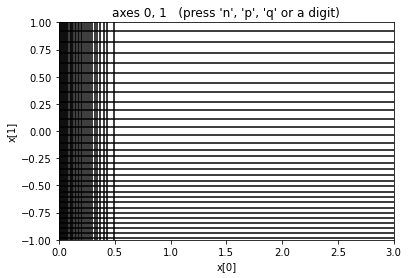

In [37]:
sigmaS = 5
sigmaA = 3
q = 3
L = 5
W = 3
bias = [.5,.5]

def f(x):
    return mc_iso_vegas(sigmaS, sigmaA, q, L, x[0], x[1], bias)
    
integ = vegas.Integrator([[0, W], [-1,1]])

result = integ(f, nitn=10, neval=10000)
print(result.summary())
print('Total leakage = ', result[0])
print('Left leakage = ', result[1])
print('Right leakage = ', result[2])

print('ratio of leakage Left = ', result[1]/result[0])
print('ratio of leakage Right = ', result[2]/result[0])
integ.map.show_grid(30)